**Курсовой проект по курсу "Библиотеки Python для Data Science: Numpy, Matplotlib, Scikit-learn"**

In [906]:
import numpy as np
import pandas as pd
import random

from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score as r2
from sklearn.model_selection import KFold, GridSearchCV

from sklearn.linear_model import LinearRegression

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [907]:
import warnings
warnings.filterwarnings("default")

In [908]:
matplotlib.rcParams.update({'font.size': 14})

In [909]:
TRAIN_DATASET_PATH = './project_task/train.csv'
TEST_DATASET_PATH = './project_task/test.csv'

**Функции обработки данных**

In [910]:
#Меняем категорийные переменные на бинарные
def cat_to_binary(df_data):
    df_out = df_data.copy()
    df_out = pd.get_dummies(data=df_out, columns=['Ecology_2', 'Ecology_3', 'Shops_2'], drop_first=True)
    
    return df_out

In [911]:
# Подготовка данных
def prepare_data(df_data):
    df_out = df_data.copy()

# Переименуем колонку Helthcare_2 в Healthcare_2 для единообразия.
    df_out.rename(columns={'Helthcare_2': 'Healthcare_2'}, inplace=True)

# Исправляем некорректные значения HouseYear
    idx = (df_out['HouseYear'] > 2020 )
    df_out.loc[idx, 'HouseYear'] = 2020

    idx = (df_out['Square'] > df_out['Square'].quantile(.99))
    df_out.loc[idx, 'Square'] = df_out['Square'].median()

    idx = (df_out['LifeSquare'] > df_out['LifeSquare'].quantile(.99))
    df_out.loc[idx, 'LifeSquare'] = np.nan
    
    idx = (df_out['LifeSquare'] < df_out['Square'] * 0.8)
    df_out.loc[idx, 'LifeSquare'] = df_out.loc[idx, 'Square'] * 0.8
      
    idx = (df_out['Floor'] > df_out['HouseFloor'])
    df_out.loc[idx, 'HouseFloor'] = df_out.loc[idx, 'Floor']
    
    idx = (df_out['Rooms'] == 0)
    df_out.loc[idx, 'Rooms'] = 1
       
    idx = (df_out['Social_3'] > 60)
    df_out.loc[idx, 'Social_3'] = 60
    
    idx = (df_out['Ecology_1'] > 0.4)
    df_out.loc[idx, 'Ecology_1'] = 0.4
    
    return df_out

In [912]:
train_df = pd.read_csv(TRAIN_DATASET_PATH, sep=",")
train_df.tail()


,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2,Price
9995,77,32,2.0,50.401785,30.476203,5.0,6,5.0,1968,0.135650,B,B,46,7960,6,350.0,3,11,B,196684.316040
9996,6159,18,1.0,41.521546,20.539216,9.0,13,13.0,2000,0.000000,B,B,30,5562,0,NaN,0,5,A,189050.289571
9997,5123,27,1.0,47.939008,NaN,1.0,12,16.0,2015,0.072158,B,B,2,629,1,NaN,0,0,A,159143.805370
9998,5400,75,2.0,43.602562,33.840147,8.0,1,5.0,1961,0.307467,B,A,30,5048,9,325.0,2,5,B,181595.339808
9999,6306,128,1.0,38.666645,21.157874,8.0,7,17.0,1990,0.000000,B,B,27,4798,0,30.0,2,8,B,218714.077615


In [913]:
train_df = cat_to_binary(train_df)

In [914]:
train_df = prepare_data(train_df)

In [915]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             10000 non-null  int64  
 1   DistrictId     10000 non-null  int64  
 2   Rooms          10000 non-null  float64
 3   Square         10000 non-null  float64
 4   LifeSquare     7808 non-null   float64
 5   KitchenSquare  10000 non-null  float64
 6   Floor          10000 non-null  int64  
 7   HouseFloor     10000 non-null  float64
 8   HouseYear      10000 non-null  int64  
 9   Ecology_1      10000 non-null  float64
 10  Social_1       10000 non-null  int64  
 11  Social_2       10000 non-null  int64  
 12  Social_3       10000 non-null  int64  
 13  Healthcare_1   5202 non-null   float64
 14  Healthcare_2   10000 non-null  int64  
 15  Shops_1        10000 non-null  int64  
 16  Price          10000 non-null  float64
 17  Ecology_2_B    10000 non-null  uint8  
 18  Ecology

**Во время работы над проектом появилась мысль заполнять пропущенные данные LifeSquare методами ML и
посмотреть, как отразится на результате**

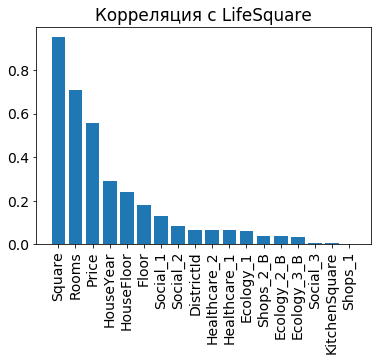

In [916]:
LS_corrmat = train_df.loc[:, train_df.columns != 'Id'  ].corrwith(
    train_df['LifeSquare']).abs().sort_values(ascending=False)[1:]
plt.bar(LS_corrmat.index, LS_corrmat.values)
plt.title('Корреляция c LifeSquare')
plt.xticks(rotation='vertical')
plt.show()

In [917]:
LS_names = ['LifeSquare','Rooms','Square','KitchenSquare','HouseYear', 'HouseFloor']
LS_train = train_df[LS_names]
idx = LS_train['LifeSquare'].isnull()
LS_test = LS_train[idx]
idx = LS_train['LifeSquare'].notnull()
LS_train = LS_train[idx]
LS_test = LS_test.drop(['LifeSquare'],axis =1)

LS_y = LS_train['LifeSquare']
LS_X = LS_train.drop(['LifeSquare'], axis = 1)

LS_X_train, LS_X_valid, LS_y_train, LS_y_valid = train_test_split(LS_X, LS_y, test_size=0.3, shuffle=True, random_state=21)

LS_scaler = StandardScaler()

LS_X_train_scaled = LS_scaler.fit_transform(LS_X_train)
LS_X_valid_scaled = LS_scaler.transform(LS_X_valid)

LS_model = RandomForestRegressor(n_estimators = 220, min_samples_split=2,max_depth=6, 
                                 min_samples_leaf=1, max_features=0.6,
                                 criterion='mse', random_state=42)
LS_model.fit(LS_X_train_scaled, LS_y_train)
#{'n_estimators': 220, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.6, 'max_depth': 6}

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=6, max_features=0.6, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=220, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

In [918]:
LS_y_train_pred = LS_model.predict(LS_X_train_scaled)
LS_y_valid_pred = LS_model.predict(LS_X_valid_scaled)
score_train = r2(LS_y_train, LS_y_train_pred)
score_valid = r2(LS_y_valid, LS_y_valid_pred)
print("Train R2:\t" + str(round(r2(LS_y_train, LS_y_train_pred), 3)))
print("Test R2:\t" + str(round(r2(LS_y_valid, LS_y_valid_pred), 3)))

Train R2:	0.964
Test R2:	0.95


In [919]:
LS_X_test_scaled = LS_scaler.fit_transform(LS_test)

In [920]:
LS_y_pred = LS_model.predict(LS_X_test_scaled)

LS_pred = pd.DataFrame({'LifeSquare': LS_y_pred})
LS_pred = LS_pred.set_index(LS_test.index)
train_df.update(LS_pred)

**Решил повторить с Healthcare_1**

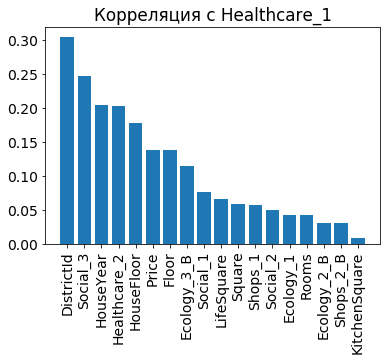

In [921]:
HC_corrmat = train_df.loc[:, train_df.columns != 'Id'  ].corrwith(
    train_df['Healthcare_1']).abs().sort_values(ascending=False)[1:]
plt.bar(HC_corrmat.index, HC_corrmat.values)
plt.title('Корреляция c Healthcare_1')
plt.xticks(rotation='vertical')
plt.show()

In [922]:
HC_names = ['Healthcare_1','DistrictId','Social_3','Healthcare_2','HouseYear', 'HouseFloor','Ecology_3_B','Social_1',
            'Social_1', 'Floor', 'LifeSquare']
HC_train = train_df[HC_names]

idx = HC_train['Healthcare_1'].isnull()
HC_test = HC_train[idx]
HC_test = HC_test.drop(['Healthcare_1'],axis = 1)

idx = HC_train['Healthcare_1'].notnull()
HC_train = HC_train[idx]

In [923]:
HC_y = HC_train['Healthcare_1']
HC_X = HC_train.drop(['Healthcare_1'], axis = 1)

HC_X_train, HC_X_valid, HC_y_train, HC_y_valid = train_test_split(HC_X, HC_y, test_size=0.3, shuffle=True, random_state=21)

HC_scaler = StandardScaler()

HC_X_train_scaled = HC_scaler.fit_transform(HC_X_train)
HC_X_valid_scaled = HC_scaler.transform(HC_X_valid)

HC_model = RandomForestRegressor(n_estimators = 200, min_samples_split=2,max_depth=50, 
                                 min_samples_leaf=1, max_features=0.7,
                                 criterion='mse', random_state=42)
HC_model.fit(HC_X_train_scaled, HC_y_train)

#{'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.7, 'max_depth': 50}

HC_y_train_pred = HC_model.predict(HC_X_train_scaled)
HC_y_valid_pred = HC_model.predict(HC_X_valid_scaled)
score_train = r2(HC_y_train, HC_y_train_pred)
score_valid = r2(HC_y_valid, HC_y_valid_pred)
print("Train R2:\t" + str(round(r2(HC_y_train, HC_y_train_pred), 3)))
print("Test R2:\t" + str(round(r2(HC_y_valid, HC_y_valid_pred), 3)))

Train R2:	0.999
Test R2:	0.994


In [924]:
HC_X_test_scaled = HC_scaler.fit_transform(HC_test)

In [925]:
HC_y_pred = HC_model.predict(HC_X_test_scaled)

HC_pred = pd.DataFrame({'Healthcare_1': HC_y_pred})
HC_pred = HC_pred.set_index(HC_test.index)
train_df.update(HC_pred)

**Анализ данных**

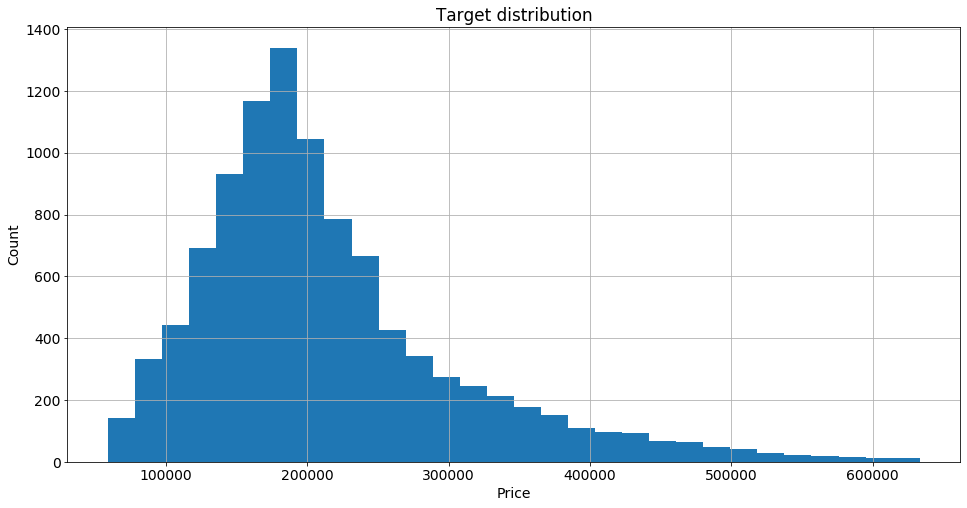

In [926]:
plt.figure(figsize = (16, 8))

train_df['Price'].hist(bins=30)
plt.ylabel('Count')
plt.xlabel('Price')

plt.title('Target distribution')
plt.show()

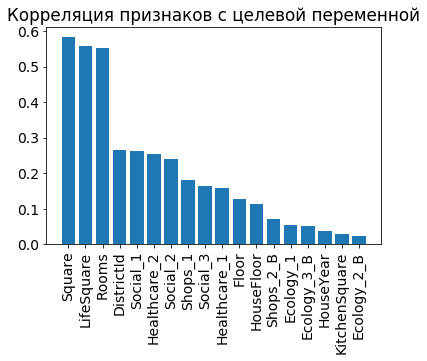

In [927]:
corrmat = train_df.loc[:, train_df.columns != 'Id'].corrwith(
    train_df['Price']).abs().sort_values(ascending=False)[1:]
plt.bar(corrmat.index, corrmat.values)
plt.title('Корреляция признаков с целевой переменной')
plt.xticks(rotation='vertical')
plt.show()

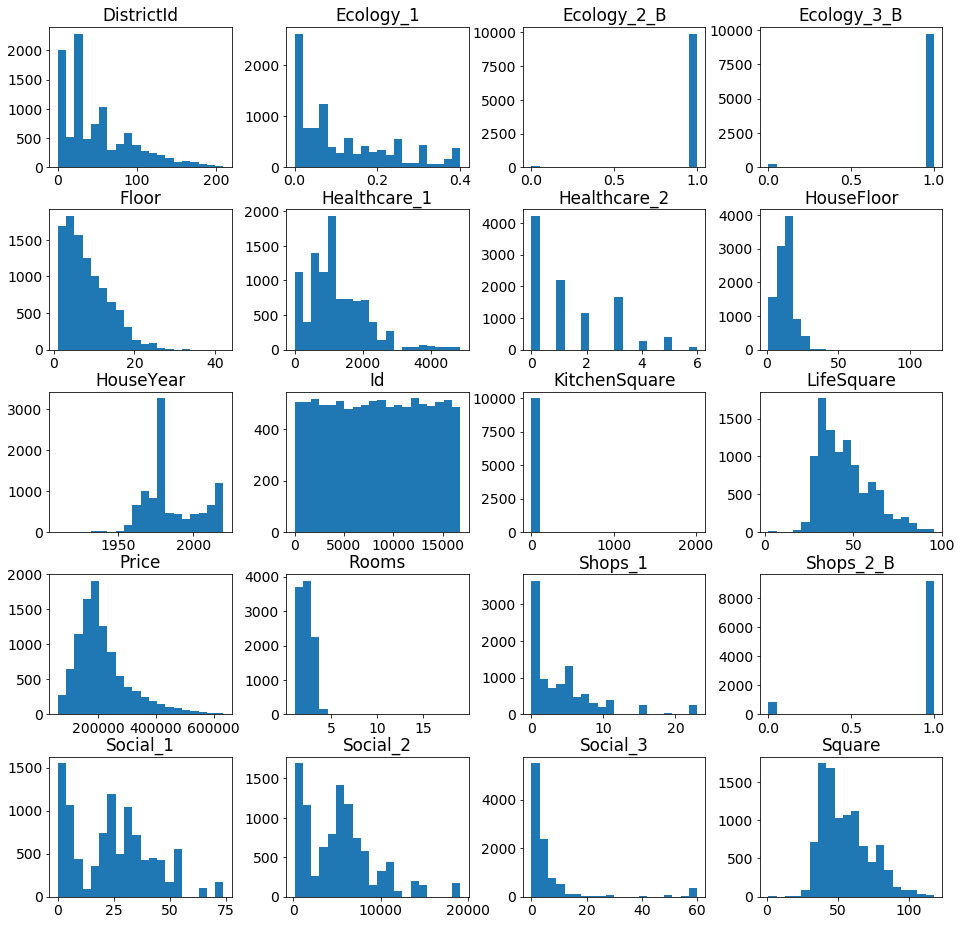

In [928]:
train_df.hist(figsize=(16,16), bins=20, grid=False);

In [929]:
feature_names = ['DistrictId','Rooms','Square', 'LifeSquare', 'KitchenSquare','Floor', 'HouseFloor', 'HouseYear',
                 'Ecology_1', 'Ecology_3_B','Social_2', 'Social_3',
                 'Healthcare_1', 'Healthcare_2', 'Shops_1', 'Shops_2_B']
target_name = 'Price'

Интересно, что без признака 'KitchenSquare' показатель R2 на тесте остаётся 0.736. Но вот проверить результат на kaggle.com
не получается уже. Загрузки кончились

In [930]:
X = train_df[feature_names]
y = train_df[target_name]

In [931]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.33, shuffle=True, random_state=21)

In [932]:
scaler = StandardScaler()

X_train_scaled = scaler.fit_transform(X_train)
rf_model = RandomForestRegressor(n_estimators = 420, min_samples_split=5,max_depth=16, 
                                 min_samples_leaf=1, max_features=0.5,
                                 criterion='mse', random_state=21)
rf_model.fit(X_train_scaled, y_train)

#{'n_estimators': 360, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 0.6, 'max_depth': 32}
#{'n_estimators': 420, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_features': 0.5, 'max_depth': 16}

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=16, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=420, n_jobs=None, oob_score=False,
                      random_state=21, verbose=0, warm_start=False)

In [933]:
X_valid_scaled = scaler.transform(X_valid)

y_train_preds = rf_model.predict(X_train_scaled)
y_valid_preds = rf_model.predict(X_valid_scaled)

In [934]:
print("Train R2:\t" + str(round(r2(y_train, y_train_preds), 3)))
print("Test R2:\t" + str(round(r2(y_valid, y_valid_preds), 3)))

Train R2:	0.924
Test R2:	0.736


In [935]:
# обучение модели на всём массиве данных

X_scaled = scaler.fit_transform(X)
rf_model.fit(X_scaled, y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=16, max_features=0.5, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=5, min_weight_fraction_leaf=0.0,
                      n_estimators=420, n_jobs=None, oob_score=False,
                      random_state=21, verbose=0, warm_start=False)

In [936]:
feature_importances = pd.DataFrame(zip(X_train.columns, rf_model.feature_importances_), 
                                   columns=['feature_name', 'importance'])

feature_importances.sort_values(by='importance', ascending=False)

,feature_name,importance
2,Square,0.241610
1,Rooms,0.139431
9,Social_2,0.131631
3,LifeSquare,0.124118
10,Social_3,0.072626
0,DistrictId,0.061471
7,Ecology_1,0.042924
6,HouseYear,0.039848
11,Healthcare_1,0.038283
5,HouseFloor,0.031507


In [937]:
test_df = pd.read_csv(TEST_DATASET_PATH, sep=",")
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Ecology_2,Ecology_3,Social_1,Social_2,Social_3,Healthcare_1,Helthcare_2,Shops_1,Shops_2
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,B,B,36,5992,0,NaN,1,1,B
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,B,B,1,264,0,NaN,0,1,B
4997,5783,12,3.0,77.842178,48.282625,9.0,23,22.0,1989,0.090799,B,B,74,19083,2,NaN,5,15,B
4998,4780,62,2.0,81.305222,NaN,0.0,4,0.0,1977,0.072158,B,B,2,629,1,NaN,0,0,A
4999,12504,30,2.0,60.555693,NaN,1.0,10,17.0,1977,0.000078,B,B,22,6398,141,1046.0,3,23,B


In [938]:
test_df = cat_to_binary(test_df)
test_df = prepare_data(test_df)

In [939]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 19 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             5000 non-null   int64  
 1   DistrictId     5000 non-null   int64  
 2   Rooms          5000 non-null   float64
 3   Square         5000 non-null   float64
 4   LifeSquare     3919 non-null   float64
 5   KitchenSquare  5000 non-null   float64
 6   Floor          5000 non-null   int64  
 7   HouseFloor     5000 non-null   float64
 8   HouseYear      5000 non-null   int64  
 9   Ecology_1      5000 non-null   float64
 10  Social_1       5000 non-null   int64  
 11  Social_2       5000 non-null   int64  
 12  Social_3       5000 non-null   int64  
 13  Healthcare_1   2623 non-null   float64
 14  Healthcare_2   5000 non-null   int64  
 15  Shops_1        5000 non-null   int64  
 16  Ecology_2_B    5000 non-null   uint8  
 17  Ecology_3_B    5000 non-null   uint8  
 18  Shops_2_

In [940]:
LS_train = test_df[LS_names]
idx = LS_train['LifeSquare'].isnull()
LS_test = LS_train[idx]
LS_test = LS_test.drop(['LifeSquare'],axis =1)

LS_X_test_scaled = LS_scaler.fit_transform(LS_test)
LS_y_pred = LS_model.predict(LS_X_test_scaled)

LS_pred = pd.DataFrame({'LifeSquare': LS_y_pred})
LS_pred = LS_pred.set_index(LS_test.index)
test_df.update(LS_pred)

In [941]:
HC_train = test_df[HC_names]
idx = HC_train['Healthcare_1'].isnull()
HC_test = HC_train[idx]
HC_test = HC_test.drop(['Healthcare_1'],axis =1)

HC_X_test_scaled = HC_scaler.fit_transform(HC_test)
HC_y_pred = HC_model.predict(HC_X_test_scaled)

HC_pred = pd.DataFrame({'Healthcare_1': HC_y_pred})
HC_pred = HC_pred.set_index(HC_test.index)
test_df.update(HC_pred)

In [942]:
X_test = test_df[feature_names]
X_test_scaled = scaler.fit_transform(X_test)
y_pred = rf_model.predict(X_test_scaled)

In [943]:
predictions = pd.DataFrame({
    'Price': y_pred
})

In [944]:
predictions.set_index(test_df.index)

,Price
0,176523.387585
1,224974.178184
2,173471.334536
3,321474.863773
4,147099.507819
...,...
4995,254045.471493
4996,132472.160084
4997,328332.715503
4998,198953.963338


In [901]:
test_df['Price']=0
test_df.update(predictions)

In [902]:
test_df.tail()

,Id,DistrictId,Rooms,Square,LifeSquare,KitchenSquare,Floor,HouseFloor,HouseYear,Ecology_1,Social_1,Social_2,Social_3,Healthcare_1,Healthcare_2,Shops_1,Ecology_2_B,Ecology_3_B,Shops_2_B,Price
4995,8180,11,3.0,67.133911,50.809797,6.0,5,9.0,1973,0.000170,36,5992,0,1935.205,1,1,1,1,1,289590.116205
4996,4695,1,1.0,40.198472,21.807061,10.0,12,17.0,2017,0.007122,1,264,0,682.980,0,1,1,1,1,130720.473983
4997,5783,12,3.0,77.842178,48.282625,9.0,23,23.0,1989,0.090799,74,19083,2,943.315,5,15,1,1,1,341348.886765
4998,4780,62,2.0,81.305222,32.830730,0.0,4,4.0,1977,0.072158,2,629,1,1223.850,0,0,1,1,0,200741.799561
4999,12504,30,2.0,60.555693,32.830730,1.0,10,17.0,1977,0.000078,22,6398,60,1046.000,3,23,1,1,1,187317.577327


In [903]:
solutions_field = ['Id', 'Price']
solution_df=test_df[solutions_field]

In [904]:
solution_df.to_csv('EChaptykov_predictions.csv', sep=',', index=False, encoding='utf-8')

Загрузил результаты на kaggle.com. Результат этой тетрадки - 0,7335
До экспериментов с Healthcare_1 Результат был 0,7338 :)

Ксения, я пробовал экспериментировать с разными новыми признаками по примеру MedPriceByDistrict.
При этом показатель R2 модели растёт на тренировочных данных, но возникает проблема при формировании значений новых 
признаков у теста. Пробовал заполнять признак в тесте средними значениями из тренировочных данных для пары,
например 'District','Rooms', но результат оценки упал в минус на kaggle.com

В общем, ещё учиться и учиться...
